In [ ]:
import os
import gc
import json

import re
import numpy as np
import pandas as pd
import scipy
import math

import cv2
from PIL import Image
import PIL

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
#from sklearn.metrics import cohen_kappa_score, accuracy_score

import random

random.seed(42)

from tqdm import tqdm
%matplotlib inline
#from keras.preprocessing import image
import glob
import tensorflow.keras.applications.densenet as dense

2024-08-21 07:00:15.215492: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 07:00:15.215590: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 07:00:15.342508: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib.colors import LinearSegmentedColormap

from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Activation, Add, Dense, Conv2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.utils import plot_model

In [ ]:
# Define the path where our dataset is stored
dataset_path = '/content/drive/MyDrive/alalade/siim-isic-melanoma-classification'

# Retrieve the names of all folders (representing cancer types) within the directory
cancer_types = os.listdir(dataset_path)

# Set to store unique image dimensions for the entire dataset
all_dimensions_set = set()

# Iterate over each classification type to process images
for cancer_type in cancer_types:
    folder_path = os.path.join(dataset_path, cancer_type)

    # Verify that the current item is a directory
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]

        # Display the count of images in the current folder
        num_images = len(image_files)
        print(f"{cancer_type} folder contains {num_images} images.")

        # # Loop over each image to check its dimensions
        # for image_file in image_files:
        #     image_path = os.path.join(folder_path, image_file)
        #     with Image.open(image_path) as img:
        #         # Extract the width, height, and channels (color depth) of the image and add to the dimensions set
        #         width, height = img.size
        #         channels = len(img.getbands())
        #         all_dimensions_set.add((width, height, channels))

# # Determine if all images in the entore dataset have the same dimensions
# if len(all_dimensions_set) == 1:
#     width, height, channel = all_dimensions_set.pop()
#     print(f"\nAll images in the dataset have the same dimensions: {width}x{height} with {channels} color channels.")
# else:
#     print("\nThe images in the dataset have different dimensions or color channels.")

melanoma folder contains 1042 images.
benign folder contains 4352 images.


In [ ]:
# Initialize an empty list to store image file paths and their respective labels
data = []
cancer_types = ['melanoma', 'benign']
# Loop through each garbage type and collect its images' file paths
for cancer_type in cancer_types:
    for file in os.listdir(os.path.join(dataset_path, cancer_type)):
        # Append the image file path and its type (as a label) to the data list
        data.append((os.path.join(dataset_path, cancer_type, file), cancer_type))

# Convert the collected data into a DataFrame
df = pd.DataFrame(data, columns=['filepath', 'label'])

# Display the first few entries of the DataFrame
df.head()

In [ ]:
# Split with stratification
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Print the number of images in each set
print(f"Number of images in the training set: {len(train_df)}")
print(f"Number of images in the validation set: {len(val_df)}")

Number of images in the training set: 4315
Number of images in the validation set: 1079


In [ ]:
# Slight Augmentation settings for training
train_datagen = ImageDataGenerator(
    rescale=1./255,                     # Normalize pixel values to [0,1]
    rotation_range=45,                  # Randomly rotate the images by up to 45 degrees
    width_shift_range=0.15,             # Randomly shift images horizontally by up to 15% of the width
    height_shift_range=0.15,            # Randomly shift images vertically by up to 15% of the height
    zoom_range=0.15,                    # Randomly zoom in or out by up to 15%
    horizontal_flip=True,               # Randomly flip images horizontally
    vertical_flip=True,                 # Randomly flip images vertically
    shear_range=0.05,                   # Apply slight shear transformations
    brightness_range=[0.9, 1.1],        # Vary brightness between 90% to 110% of original
    channel_shift_range=10,             # Randomly shift channels (can change colors of images slightly but less aggressively)
    fill_mode='nearest'                 # Fill in missing pixels using the nearest filled value
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Using flow_from_dataframe to generate batches
# Generate training batches from the training dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,                  # DataFrame containing training data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)


# Generate validation batches from the validation dataframe
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,                    # DataFrame containing validation data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)

Found 4315 validated image filenames belonging to 2 classes.
Found 1079 validated image filenames belonging to 2 classes.


In [ ]:
print(f"Number of batches in train_generator: {len(train_generator)}")
print(f"Number of batches in val_generator: {len(val_generator)}")

Number of batches in train_generator: 135
Number of batches in val_generator: 34


In [ ]:
# Extract class labels from the 'label' column of train_df
class_labels = train_df['label'].unique()
class_labels

array(['benign', 'melanoma'], dtype=object)

In [ ]:
train_generator.class_indices

{'benign': 0, 'melanoma': 1}

In [ ]:
# Compute class weights
weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=train_df['label'])
weights

array([0.61979316, 2.58693046])

In [ ]:
# Convert the computed weights to a dictionary for passing to model training
class_weights = dict(zip(train_generator.class_indices.values(), weights))
class_weights

{0: 0.6197931628842287, 1: 2.5869304556354917}

In [ ]:
def plot_learning_curves(history, start_epoch=5):
    """
    Plot training and validation loss and accuracy curves.

    Parameters:
    - history: Training history (output from the model's fit method).
    - start_epoch: Epoch from which to start plotting. Default is 5 (i.e., plot from epoch 6 onwards).
    """

    # Convert the history.history dict to a pandas DataFrame
    df = pd.DataFrame(history.history)

    # Plot the curves from the specified epoch onwards
    df = df.iloc[start_epoch-1:]

    # Set the style of seaborn for better visualization
    sns.set(rc={'axes.facecolor': '#f0f0fc'}, style='darkgrid')

    # Plotting the learning curves
    plt.figure(figsize=(15,6))

    # Plotting the training and validation loss
    plt.subplot(1, 2, 1)
    sns.lineplot(x=df.index, y=df['loss'], color='royalblue', label='Train Loss')
    sns.lineplot(x=df.index, y=df['val_loss'], color='orangered', linestyle='--', label='Validation Loss')
    plt.title('Loss Evolution')

    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    sns.lineplot(x=df.index, y=df['accuracy'], color='royalblue', label='Train Accuracy')
    sns.lineplot(x=df.index, y=df['val_accuracy'], color='orangered', linestyle='--', label='Validation Accuracy')
    plt.title('Accuracy Evolution')

    plt.show()

In [ ]:
def evaluate_model_performance(model, val_generator, class_labels):
    """
    Evaluate the model's performance on the validation set and print the classification report.

    Parameters:
    - model: The trained model.
    - val_generator: Validation data generator.
    - class_labels: List of class names.

    Returns:
    - report: Classification report as a string.
    """

    # Getting all the true labels for the validation set
    true_labels = val_generator.classes

    # Get the class labels (names) from the generator
    class_labels = list(val_generator.class_indices.keys())

    # To get the predicted labels, we predict using the model
    predictions = model.predict(val_generator, steps=len(val_generator))

    # Take the argmax to get the predicted class indices.
    predicted_labels = np.argmax(predictions, axis=1)

    # Extracting true labels from the validation generator
    true_labels = val_generator.classes

    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')

    # Define a custom colormap
    colors = ["white", "royalblue"]
    cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plotting confusion matrix using seaborn
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap=cmap_cm, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
# Load the ResNet50 model with weights pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(384, 384, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 384, 384,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 390, 390,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 192, 192,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 192, 192,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 192, 192,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 194, 194,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 96, 96,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 96, 96,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 96, 96,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 96, 96,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 96, 96,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 96, 96,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 96, 96,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 96, 96,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 96, 96,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 96, 96,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 96, 96,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# Freeze the layers up to conv4_block6_out
for layer in base_model.layers[:143]: # include the layer 142
    layer.trainable = False

In [ ]:
# Create the new model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax')(x)

transfer_resnet50_model = Model(inputs=base_model.input, outputs=x)

# Compile the model
transfer_resnet50_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
transfer_resnet50_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 384, 384,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 390, 390,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 192, 192,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 192, 192,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 192, 192,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 194, 194,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 96, 96,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 96, 96,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 96, 96,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 96, 96,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 96, 96,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 96, 96,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 96, 96,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 96, 96,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 96, 96,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 96, 96,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 96, 96,    │      1,024 │ conv2_block1_3_c

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 14,980,098 (57.14 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

In [ ]:
# Slight Augmentation settings for training
train_datagen = ImageDataGenerator(
    rotation_range=60,                  # Randomly rotate the images by up to 60 degrees
    width_shift_range=0.15,             # Randomly shift images horizontally by up to 15% of the width
    height_shift_range=0.15,            # Randomly shift images vertically by up to 15% of the height
    zoom_range=0.20,                    # Randomly zoom in or out by up to 20%
    horizontal_flip=True,               # Randomly flip images horizontally
    vertical_flip=True,                 # Randomly flip images vertically
    shear_range=0.05,                   # Apply slight shear transformations
    brightness_range=[0.9, 1.1],        # Vary brightness between 90% to 110% of original
    channel_shift_range=10,             # Randomly shift channels (can change colors of images slightly but less aggressively)
    fill_mode='nearest',                 # Fill in missing pixels using the nearest filled value
    preprocessing_function=preprocess_input  # Add this line
)

# For the validation set, you might not have augmentation:
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)  # Add this line

In [ ]:
# Using flow_from_dataframe to generate batches
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,                  # DataFrame containing training data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)


# Generate validation batches from the validation dataframe
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,                    # DataFrame containing validation data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)

Found 4315 validated image filenames belonging to 2 classes.
Found 1079 validated image filenames belonging to 2 classes.


In [ ]:
# Define the callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True, verbose=1)

# Total number of epochs
num_epochs = 10

# Train the model
history = transfer_resnet50_model.fit(train_generator,
                                      steps_per_epoch=55,
                                      epochs=num_epochs,
                                      validation_data=val_generator,
                                      validation_steps=15,
                                      class_weight=class_weights,
                                      callbacks=[reduce_lr, early_stopping])

Epoch 1/10


I0000 00:00:1723977021.748292    3675 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1723977021.822949    3675 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5951 - loss: 0.7657

W0000 00:00:1723977175.777136    3674 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


55/55 ━━━━━━━━━━━━━━━━━━━━ 237s 3s/step - accuracy: 0.5964 - loss: 0.7640 - val_accuracy: 0.8271 - val_loss: 0.5072 - learning_rate: 1.0000e-04
Epoch 2/10
 3/55 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - accuracy: 0.7309 - loss: 0.5969  

W0000 00:00:1723977227.529687    3672 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


55/55 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.7117 - loss: 0.5909 - val_accuracy: 0.8292 - val_loss: 0.7117 - learning_rate: 1.0000e-04
Epoch 3/10
25/55 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.7406 - loss: 0.5051

W0000 00:00:1723977427.617209    3674 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


55/55 ━━━━━━━━━━━━━━━━━━━━ 51s 944ms/step - accuracy: 0.7335 - loss: 0.5150 - val_accuracy: 0.8487 - val_loss: 0.4584 - learning_rate: 1.0000e-04
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - accuracy: 0.7856 - loss: 0.4894 - val_accuracy: 0.8458 - val_loss: 0.4856 - learning_rate: 1.0000e-04
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.7966 - loss: 0.4320 - val_accuracy: 0.8271 - val_loss: 0.3689 - learning_rate: 1.0000e-04
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 38s 699ms/step - accuracy: 0.7612 - loss: 0.4683 - val_accuracy: 0.8403 - val_loss: 0.4186 - learning_rate: 1.0000e-04
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.8142 - loss: 0.3876 - val_accuracy: 0.8542 - val_loss: 0.3845 - learning_rate: 1.0000e-04
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - accuracy: 0.8294 - loss: 0.3696 - val_accuracy: 0.8354 - val_loss: 0.3985 - learning_rate: 1.0000e-04
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 39s 717ms/step - accuracy: 0.8153 - los

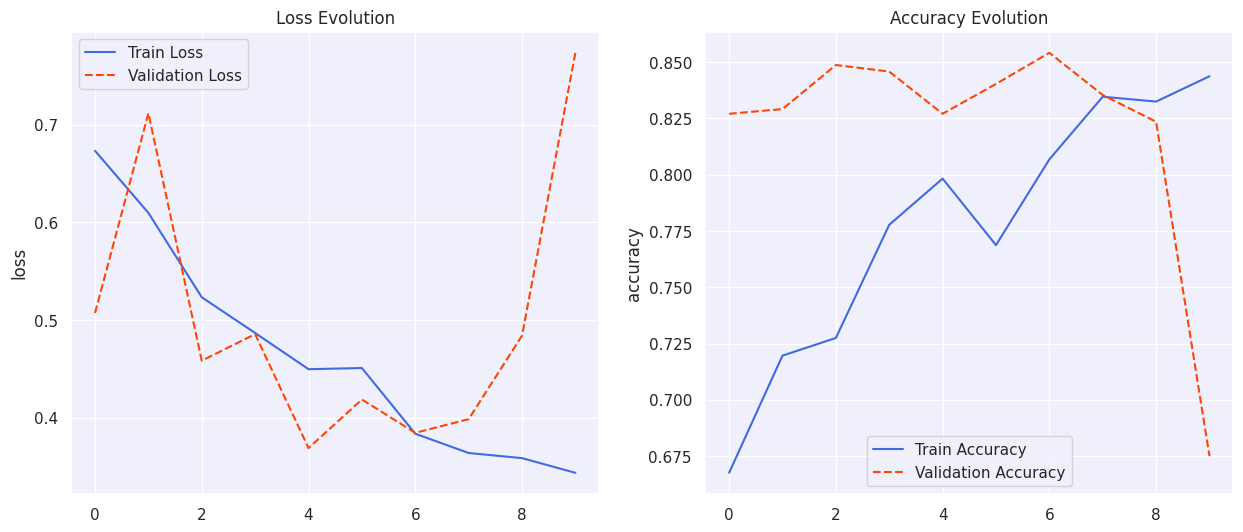

In [ ]:
plot_learning_curves(history, start_epoch=1)

 1/34 ━━━━━━━━━━━━━━━━━━━━ 2:49 5s/step

W0000 00:00:1723978308.984383    3672 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step


W0000 00:00:1723978347.181245    3674 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


              precision    recall  f1-score   support

      benign       0.93      0.87      0.90       871
    melanoma       0.58      0.71      0.64       208

    accuracy                           0.84      1079
   macro avg       0.75      0.79      0.77      1079
weighted avg       0.86      0.84      0.85      1079





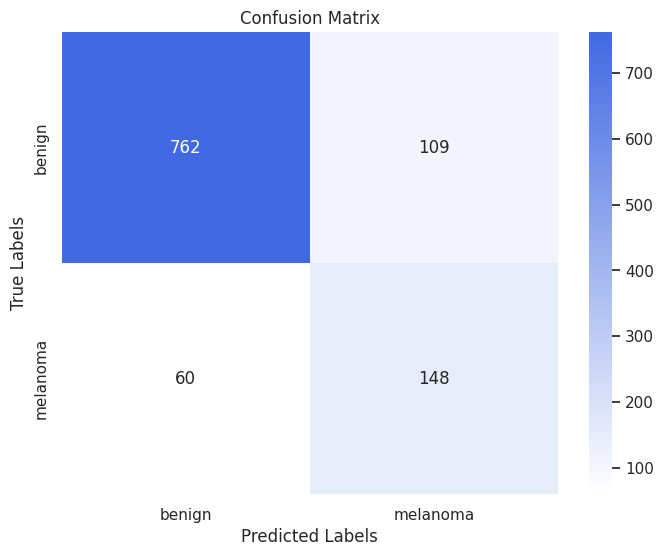

In [ ]:
evaluate_model_performance(transfer_resnet50_model, val_generator, class_labels)

## Big Transfer (BiT) Model
### BiT-M-R50x1 model

This model is based on ResNet-50 architecture. The "M" in the name indicates that the model was pre-trained on the ImageNet-21k dataset, and "R50x1" denotes the ResNet-50 architecture with standard width (1x).
It is particularly optimized for transfer learning

In [ ]:
## BigTransfer (BiT) family

import tf_keras
import tensorflow_hub as hub
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_module = hub.KerasLayer(bit_model_url, trainable=True)

In [ ]:
import random
import sys
seed = random.randrange(sys.maxsize)
rng = random.Random(seed)
print("Seed was:", seed)

Seed was: 1026847926404610461


In [ ]:
data_dr = "/content/drive/MyDrive/alalade/siim-isic-melanoma-classification"

batch_size = 32
img_size = (224, 224)

train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int',
    class_names=['benign', 'melanoma']
)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int',
    class_names=['benign', 'melanoma']
)

Found 5394 files belonging to 2 classes.
Using 4316 files for training.
Found 5394 files belonging to 2 classes.
Using 1078 files for validation.


In [ ]:
# Using flow_from_dataframe to generate batches
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,                  # DataFrame containing training data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)


# Generate validation batches from the validation dataframe
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,                    # DataFrame containing validation data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)

Found 4315 validated image filenames belonging to 2 classes.
Found 1079 validated image filenames belonging to 2 classes.


In [ ]:
num_classes = 2

model = tf_keras.Sequential([
    hub.KerasLayer(bit_model_url, trainable=True),
    tf_keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model.compile(
    optimizer=tf_keras.optimizers.Adam(),
    loss=tf_keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
epochs = 20

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
135/135 [==============================] - 173s 715ms/step - loss: 0.9602 - accuracy: 0.7750 - val_loss: 0.4817 - val_accuracy: 0.8043
Epoch 2/20
135/135 [==============================] - 85s 630ms/step - loss: 0.5062 - accuracy: 0.7963 - val_loss: 0.4828 - val_accuracy: 0.8043
Epoch 3/20
135/135 [==============================] - 86s 633ms/step - loss: 0.4674 - accuracy: 0.8063 - val_loss: 0.4912 - val_accuracy: 0.8043
Epoch 4/20
135/135 [==============================] - 85s 628ms/step - loss: 0.4943 - accuracy: 0.7943 - val_loss: 0.4544 - val_accuracy: 0.8043
Epoch 5/20
135/135 [==============================] - 85s 629ms/step - loss: 0.4565 - accuracy: 0.8014 - val_loss: 0.4465 - val_accuracy: 0.8043
Epoch 6/20
135/135 [==============================] - 86s 633ms/step - loss: 0.4546 - accuracy: 0.7961 - val_loss: 0.5001 - val_accuracy: 0.8043
Epoch 7/20
135/135 [==============================] - 86s 631ms/step - loss: 0.4436 - accuracy: 0.8056 - val_loss: 0.4630 - val_a

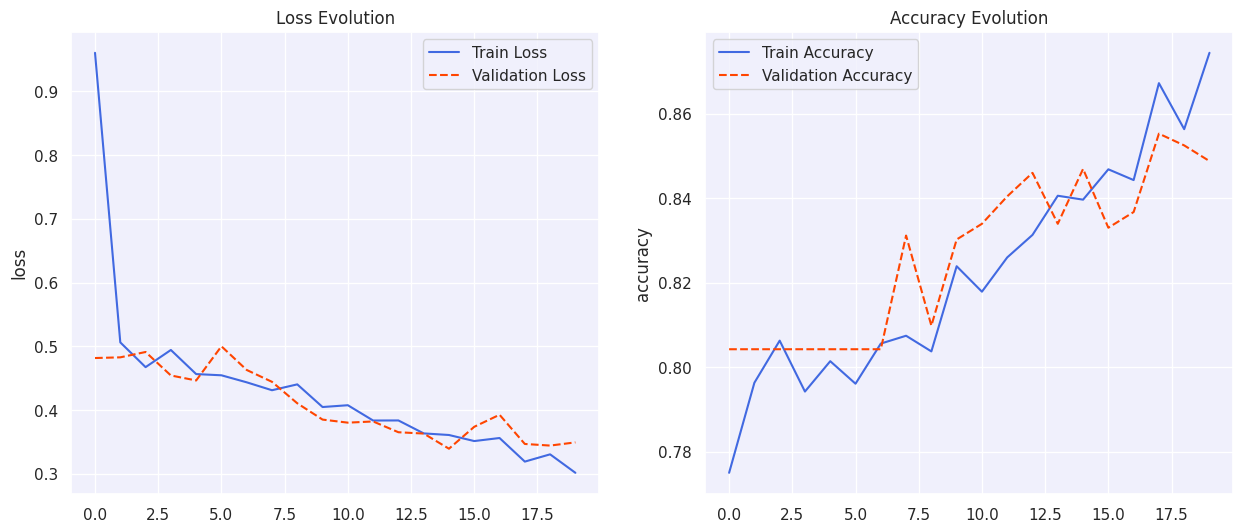

In [ ]:
plot_learning_curves(history, start_epoch=1)

In [ ]:
def evaluate_model_performance_bit(model, val_ds, class_labels):
    """
    Evaluate the model's performance on the validation set and print the classification report.

    Args:
    - model: Trained TensorFlow/Keras model.
    - val_ds: Validation dataset (tf.data.Dataset).
    - class_labels: List of class names.

    Returns:
    - report: Classification report as a string.
    """

    # Get the true labels and predictions
    true_labels = []
    predictions = []

    for images, labels in val_ds:
        preds = model.predict(images)
        true_labels.extend(labels.numpy())
        predictions.extend(np.argmax(preds, axis=1))

    # Convert true labels to a flat array
    true_labels = np.array(true_labels).flatten()

    # Generate a classification report
    report = classification_report(true_labels, predictions, target_names=class_labels)

    print(report)
    print('\n')

    # Define a custom colormap
    colors = ["white", "royalblue"]
    cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predictions)

    # Plotting confusion matrix using seaborn
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap=cmap_cm, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

1/1 [==============================] - 1s 1s/step
              precision    recall  f1-score   support

      benign       0.87      0.95      0.91       867
    melanoma       0.68      0.42      0.52       211

    accuracy                           0.85      1078
   macro avg       0.78      0.69      0.72      1078
weighted avg       0.83      0.85      0.83      1078





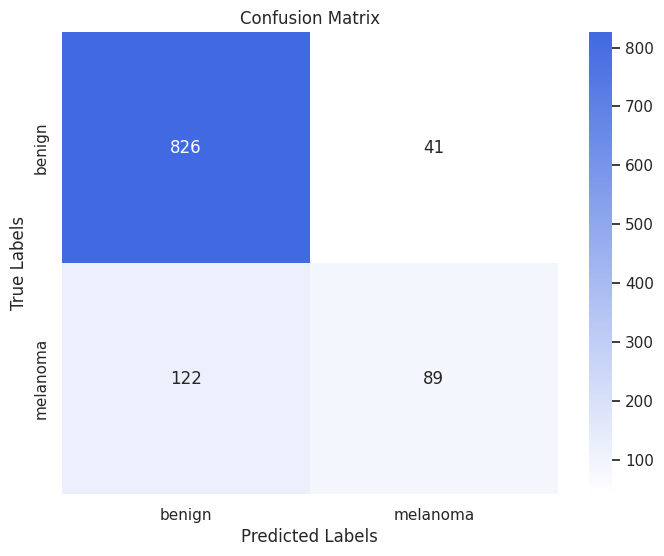

In [ ]:
evaluate_model_performance_bit(
    model, val_ds, class_labels
)

## Image Preprocessing

## Model Building

In [ ]:
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input
from keras.callbacks import EarlyStopping
from keras.layers import RandomFlip, RandomRotation

In [ ]:
Augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
])

In [ ]:
def Normalizer(image, label):
    image= tf.cast(image/255., tf.float32)
    return image, label

In [ ]:
model = Sequential([
    Augmentation,
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(units=64, activation="relu"),
    Dense(units=2, activation="softmax"),
])

# model.build (input_shape=(None, 256, 256, 3))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def handle_imbalance(train_ds, batch_size, strategy='oversample'):
    """
    Handle imbalanced data by either oversampling the minority class or undersampling the majority class.

    Args:
    - train_ds: TensorFlow Dataset object (the training dataset).
    - batch_size: The batch size to use when batching the balanced dataset.
    - strategy: 'oversample' or 'undersample'.

    Returns:
    - balanced_ds: A balanced TensorFlow Dataset object.
    """
    # Extract all elements in the dataset to analyze class distribution
    all_images = []
    all_labels = []

    for images, labels in train_ds.unbatch():
        all_images.append(images.numpy())
        all_labels.append(labels.numpy())

    all_images = np.array(all_images)
    all_labels = np.array(all_labels)

    # Determine the minority and majority classes
    unique, counts = np.unique(all_labels, return_counts=True)
    class_counts = dict(zip(unique, counts))

    min_class = min(class_counts, key=class_counts.get)
    max_class = max(class_counts, key=class_counts.get)

    min_class_count = class_counts[min_class]
    max_class_count = class_counts[max_class]

    if strategy == 'oversample':
        # Oversample the minority class
        min_class_indices = np.where(all_labels == min_class)[0]
        oversample_indices = np.random.choice(min_class_indices, size=max_class_count, replace=True)

        balanced_images = np.concatenate([all_images, all_images[oversample_indices]], axis=0)
        balanced_labels = np.concatenate([all_labels, all_labels[oversample_indices]], axis=0)

    elif strategy == 'undersample':
        # Undersample the majority class
        max_class_indices = np.where(all_labels == max_class)[0]
        undersample_indices = np.random.choice(max_class_indices, size=min_class_count, replace=False)

        balanced_images = np.concatenate([all_images[min_class_indices], all_images[undersample_indices]], axis=0)
        balanced_labels = np.concatenate([all_labels[min_class_indices], all_labels[undersample_indices]], axis=0)

    # Shuffle the balanced dataset
    indices = np.arange(len(balanced_labels))
    np.random.shuffle(indices)

    balanced_images = balanced_images[indices]
    balanced_labels = balanced_labels[indices]

    # Create a new TensorFlow dataset from the balanced data
    balanced_ds = tf.data.Dataset.from_tensor_slices((balanced_images, balanced_labels))

    return balanced_ds.batch(batch_size)

In [ ]:
# Apply the Normalizer function to the datasets
train_ds = handle_imbalance(train_ds, batch_size=32, strategy='oversample')
train_ds = train_ds.map(Normalizer)
val_ds = val_ds.map(Normalizer)

In [ ]:
model.compile(
    optimizer= 'adam',
    loss=  'sparse_categorical_crossentropy',
    metrics = ['accuracy',]
)
early_stopping = EarlyStopping(
    monitor = 'accuracy',
    patience = 3,
    restore_best_weights = True,
)

In [ ]:
history = model.fit(
    train_ds, epochs=20, verbose=1,
    validation_data=val_ds, callbacks=[early_stopping]
)

Epoch 1/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 35s 97ms/step - accuracy: 0.5427 - loss: 0.6880 - val_accuracy: 0.4768 - val_loss: 0.7150
Epoch 2/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.5637 - loss: 0.6779 - val_accuracy: 0.5510 - val_loss: 0.7195
Epoch 3/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.6095 - loss: 0.6624 - val_accuracy: 0.4499 - val_loss: 0.7917
Epoch 4/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.6387 - loss: 0.6464 - val_accuracy: 0.5891 - val_loss: 0.7117
Epoch 5/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.6584 - loss: 0.6277 - val_accuracy: 0.4490 - val_loss: 0.8025
Epoch 6/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.6577 - loss: 0.6257 - val_accuracy: 0.4638 - val_loss: 0.7902
Epoch 7/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - accuracy: 0.6853 - loss: 0.6001 - val_accuracy: 0.5111 - val_loss: 0.7483
Epoch 8/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.6868 - loss: 0.5924 - 

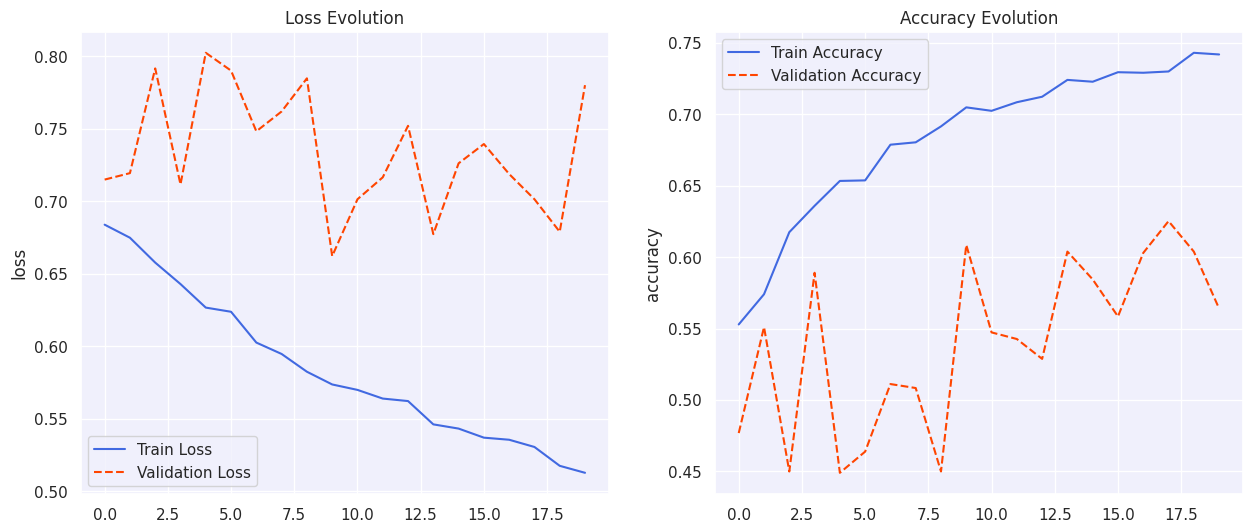

In [ ]:
plot_learning_curves(history, start_epoch=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━

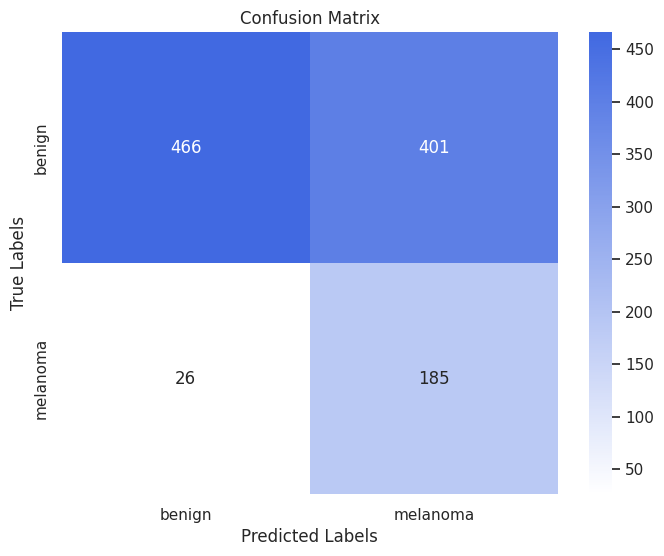

In [ ]:
evaluate_model_performance_bit(
    model, val_ds, class_labels
)

In [ ]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 20,
    horizontal_flip = True ,
    validation_split = 0.25
)
valid_gen =  ImageDataGenerator(rescale=1./255,validation_split = 0.2)
train_data = train_gen.flow_from_directory(
    data_dir, subset='training', target_size=(224,224),
    batch_size=64, color_mode='rgb',
    class_mode='categorical', shuffle=True
)

test_data = valid_gen.flow_from_directory(
    data_dir, subset='validation', target_size=(224,224),
    batch_size=64, color_mode='rgb',
    class_mode='categorical', shuffle=False
)

Found 4046 images belonging to 2 classes.
Found 1078 images belonging to 2 classes.


In [ ]:
model_1 = Sequential()

model_1.add(Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)))

model_1.add(Dropout(0.1))
model_1.add(MaxPooling2D())

model_1.add(Conv2D(64, 3, activation='relu'))
model_1.add(Dropout(0.15))
model_1.add(MaxPooling2D())

model_1.add(layers.Flatten())
model_1.add(Dense(128, activation='relu'))
model_1.add(Dense(2, activation='softmax'))

model_1.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
model_1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 109, 109, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,907,650 (91.20 MB)

 Trainable params: 23,907,650 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model_1.fit(train_data,
          validation_data=test_data,
          epochs = 10)

Epoch 1/10
 1/64 ━━━━━━━━━━━━━━━━━━━━ 36:22 35s/step - accuracy: 0.3125 - loss: 0.7134

I0000 00:00:1723987691.868754     401 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1723987691.891235     401 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7033 - loss: 3.0040

W0000 00:00:1723987846.715258     398 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


64/64 ━━━━━━━━━━━━━━━━━━━━ 261s 4s/step - accuracy: 0.7044 - loss: 2.9763 - val_accuracy: 0.8061 - val_loss: 0.5630
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 190s 3s/step - accuracy: 0.8035 - loss: 0.4696 - val_accuracy: 0.7950 - val_loss: 0.5246
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.8076 - loss: 0.4640 - val_accuracy: 0.7542 - val_loss: 0.5705
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - accuracy: 0.8346 - loss: 0.4233 - val_accuracy: 0.7430 - val_loss: 0.5765
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - accuracy: 0.8262 - loss: 0.4240 - val_accuracy: 0.7801 - val_loss: 0.5291
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 189s 3s/step - accuracy: 0.7986 - loss: 0.4851 - val_accuracy: 0.7560 - val_loss: 0.5487
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - accuracy: 0.8192 - loss: 0.4286 - val_accuracy: 0.7449 - val_loss: 0.6077
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - accuracy: 0.8166 - loss: 0.4136 - val_accuracy: 0.7607 - val_loss: 0.

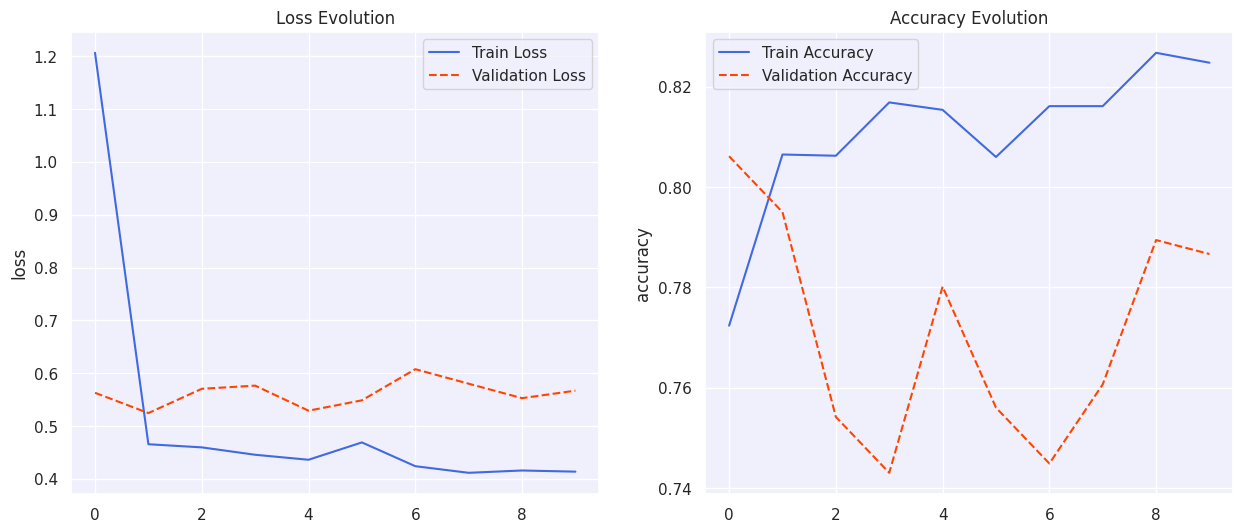

In [ ]:
plot_learning_curves(history, start_epoch=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━

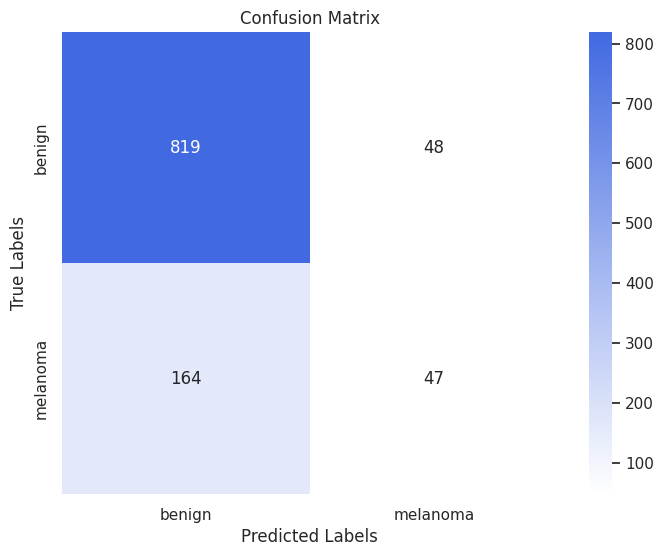

In [ ]:
evaluate_model_performance_bit(
    model_1, val_ds, class_labels
)

In [ ]:
import tensorflow as tf
import numpy as np


# Add random "hair-like" lines
def add_hair(image, num_lines=5):
    h, w, _ = image.shape
    for _ in range(num_lines):
        y1, x1 = tf.random.uniform([], 0, h, dtype=tf.int32), tf.random.uniform([], 0, w, dtype=tf.int32)
        y2, x2 = tf.random.uniform([], 0, h, dtype=tf.int32), tf.random.uniform([], 0, w, dtype=tf.int32)
        thickness = tf.random.uniform([], 1, 3, dtype=tf.int32)
        image = tf.image.draw_bounding_boxes(
            tf.expand_dims(image, 0),
            tf.expand_dims([[[y1/h, x1/w, y2/h, x2/w]]], 0),
            colors=[tf.random.uniform([3])],
            thickness=thickness
        )[0]
    return image

# Cutout: Erase a small rectangle in the image
def cutout(image, size=50):
    h, w, _ = image.shape
    y = tf.random.uniform([], 0, h, dtype=tf.int32)
    x = tf.random.uniform([], 0, w, dtype=tf.int32)
    half_size = size // 2
    y1 = tf.clip_by_value(y - half_size, 0, h)
    y2 = tf.clip_by_value(y + half_size, 0, h)
    x1 = tf.clip_by_value(x - half_size, 0, w)
    x2 = tf.clip_by_value(x + half_size, 0, w)
    mask = tf.ones([h, w, 3], dtype=tf.float32)
    mask = tf.tensor_scatter_nd_update(mask, [[y1, x1]], tf.zeros([y2-y1, x2-x1, 3], dtype=tf.float32))
    image = image * mask
    return image

def augment_image(image, label):
    # Resize image to 400x600
    image = tf.image.resize(image, [400, 600])

    # Random rotation
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # Random flip
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    # Random color jitter
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)

    image = cutout(image)

    image = add_hair(image)

    # Metadata augmentation: Add random noise
    def augment_metadata(label):
        noise = tf.random.normal(shape=tf.shape(label), mean=0.0, stddev=0.1, dtype=tf.float32)
        label = label + noise
        return label

    label = augment_metadata(label)

    return image, label

In [ ]:
# import tensorflow as tf

# def augment_image(image, label):
#     # Resize image to 400x600x
#     image = tf.image.resize(image, [400, 600])

#     # Random rotation
#     image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

#     # Random flip
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_flip_up_down(image)

#     # Random color jitter
#     image = tf.image.random_brightness(image, max_delta=0.2)
#     image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
#     image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
#     image = tf.image.random_hue(image, max_delta=0.1)

#     # Cutout: Erase a small rectangle in the image
#     def cutout(image, size=50):
#         h = tf.shape(image)[0]
#         w = tf.shape(image)[1]
#         y = tf.random.uniform([], 0, h, dtype=tf.int32)
#         x = tf.random.uniform([], 0, w, dtype=tf.int32)
#         half_size = size // 2
#         y1 = tf.clip_by_value(y - half_size, 0, h)
#         y2 = tf.clip_by_value(y + half_size, 0, h)
#         x1 = tf.clip_by_value(x - half_size, 0, w)
#         x2 = tf.clip_by_value(x + half_size, 0, w)
#         mask = tf.ones_like(image)
#         mask = tf.tensor_scatter_nd_update(mask, [[y1, x1]], tf.zeros([y2-y1, x2-x1, 3], dtype=tf.float32))
#         image = image * mask
#         return image

#     image = cutout(image)

# #     # Add random "hair-like" lines
# #     def add_hair(image, num_lines=5):
# #         h = tf.shape(image)[0]
# #         w = tf.shape(image)[1]
# #         for _ in range(num_lines):
# #             y1, x1 = tf.random.uniform([], 0, h, dtype=tf.int32), tf.random.uniform([], 0, w, dtype=tf.int32)
# #             y2, x2 = tf.random.uniform([], 0, h, dtype=tf.int32), tf.random.uniform([], 0, w, dtype=tf.int32)
# #             image = tf.image.draw_bounding_boxes(
# #                 tf.expand_dims(image, 0),
# #                 boxes=tf.constant([[[y1/h, x1/w, y2/h, x2/w]]]),
# #                 colors=tf.constant([[[0.0, 0.0, 0.0]]])  # Black hair-like lines
# #             )[0]
# #         return image

# #     image = add_hair(image)

#     # Metadata augmentation: Add random noise
#     def augment_metadata(label):
#         noise = tf.random.normal(shape=tf.shape(label), mean=0.0, stddev=0.1, dtype=tf.float32)
#         label = label  #+ noise
#         return label

#     label = augment_metadata(label)

#     return image, label

# # Apply the augmentation to your datasets
# train_ds = train_ds.map(augment_image)
# val_ds = val_ds.map(augment_image)

In [ ]:
def augment_image(image, label):
    # Resize image to 400x600
    image = tf.image.resize(image, [400, 600])

    # Random rotation
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # Random flip
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    # Random color jitter
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)

    # Cutout: Erase a small rectangle in the image
    def cutout(image, size=50):
        h = tf.shape(image)[0]
        w = tf.shape(image)[1]
        y = tf.random.uniform([], 0, h, dtype=tf.int32)
        x = tf.random.uniform([], 0, w, dtype=tf.int32)
        half_size = size // 2
        y1 = tf.clip_by_value(y - half_size, 0, h)
        y2 = tf.clip_by_value(y + half_size, 0, h)
        x1 = tf.clip_by_value(x - half_size, 0, w)
        x2 = tf.clip_by_value(x + half_size, 0, w)
        # Create a mask with the cutout region set to 0
        mask = tf.ones_like(image)
        mask = tf.tensor_scatter_nd_update(
            mask,
            indices=[[y1, x1]],
            updates=tf.zeros([y2 - y1, x2 - x1, 3], dtype=tf.float32)
        )
        image = image * mask
        return image

    image = cutout(image)

    # Metadata augmentation: Add random noise
    def augment_metadata(label):
        label = tf.cast(label, tf.float32)  # Convert label to float32
        noise = tf.random.normal(shape=tf.shape(label), mean=0.0, stddev=0.1, dtype=tf.float32)
        label = label + noise
        return label

    label = augment_metadata(label)

    return image, label

# Apply the augmentation to your datasets
train_ds = train_ds.map(augment_image)
val_ds = val_ds.map(augment_image)


In [ ]:
history = model_1.fit(train_data,
          validation_data=test_data,
          epochs = 100)

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.8608 - loss: 0.3243 - val_accuracy: 0.6929 - val_loss: 0.6968
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.8638 - loss: 0.3358 - val_accuracy: 0.7069 - val_loss: 0.7052
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.8713 - loss: 0.3009 - val_accuracy: 0.7199 - val_loss: 0.6773
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.8863 - loss: 0.2833 - val_accuracy: 0.7403 - val_loss: 0.6361
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.8745 - loss: 0.2994 - val_accuracy: 0.7078 - val_loss: 0.7505
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.8734 - loss: 0.2983 - val_accuracy: 0.7468 - val_loss: 0.7110
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.8748 - loss: 0.3056 - val_accuracy: 0.7152 - val_loss: 0.7700
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.8794 - loss: 0.2832 - val_accuracy: 0.

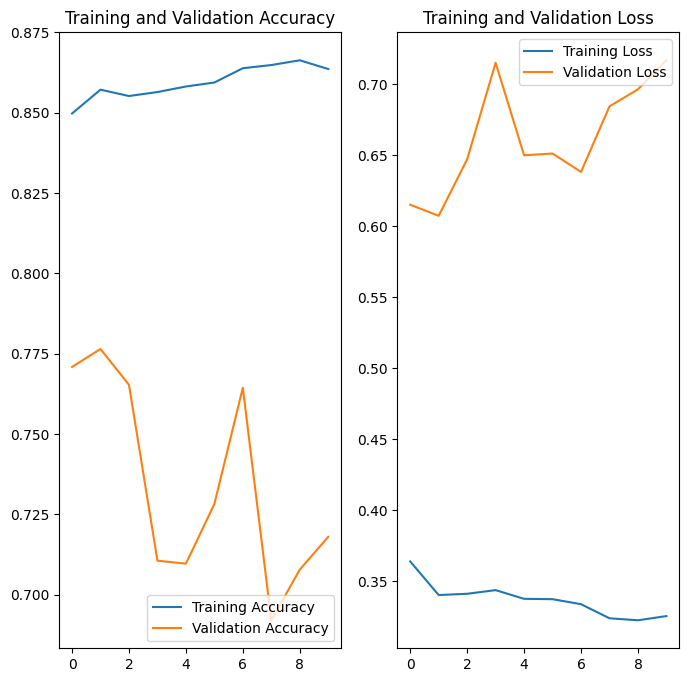

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

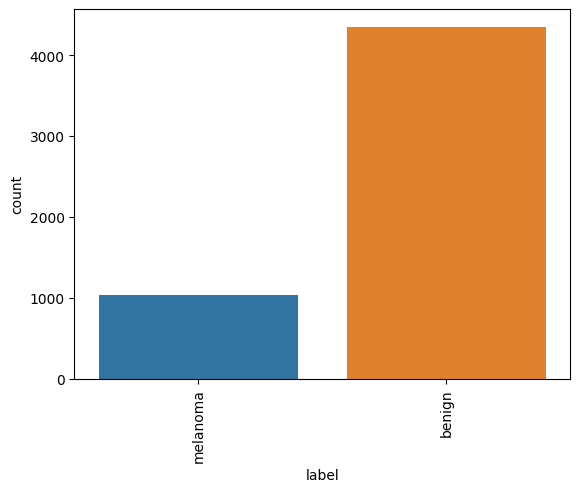

In [ ]:
sns.countplot(data=df, x="label")
plt.xticks(rotation=90)
plt.show()

### Findings

Data is hevily imbalance and hence due to that results and predictions will be baised.

In [ ]:
!pip install Augmentor

In [ ]:
import Augmentor
for i in class_labels:
    print(i)
    p = Augmentor.Pipeline(data_dir + '/' + i, output_directory='/working/data/'+i+'/output/')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000)

total training image count = 2000 

-------------------------------------
Class name =  benign
count      =  1000
proportion =  0.5
-------------------------------------
Class name =  melanoma
count      =  1000
proportion =  0.5
-------------------------------------


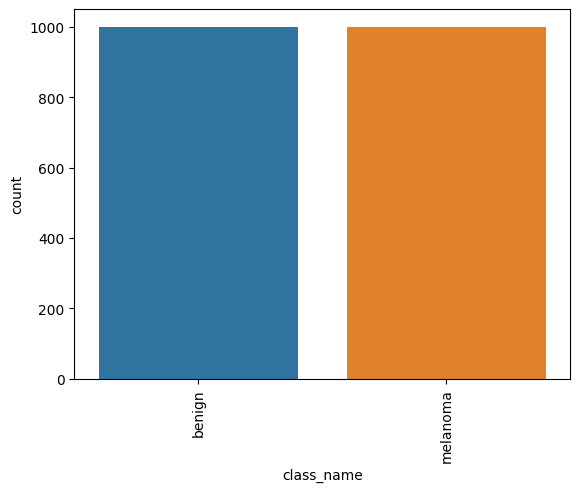

In [ ]:
import pathlib
num_classes = len(class_labels)
total = 0
all_count = []
class_name = []
output_dir = pathlib.Path('/working/data')
for i in range(num_classes):
  count = len(list(output_dir.glob(class_labels[i]+'/output/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(output_dir.glob(class_labels[i]+'/output/*.jpg')))
  print("Class name = ",class_labels[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_labels[i])


temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

#### Use Unbalanced Dataset

In [ ]:
batch_size = 32

unb_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=42,
  validation_split = 0.2,
  subset = 'training',
  image_size=(180, 180),
  batch_size=batch_size)

unb_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=42,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(180, 180),
  batch_size=batch_size)

#### performing training on unbalanced dataset

In [ ]:
epochs = 25
history = model.fit(
  unb_train_ds,
  validation_data=unb_val_ds,
  epochs=epochs
)

Epoch 1/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.8028 - loss: 0.5635

W0000 00:00:1724226331.039088      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


135/135 ━━━━━━━━━━━━━━━━━━━━ 72s 535ms/step - accuracy: 0.8029 - loss: 0.5631 - val_accuracy: 0.8043 - val_loss: 0.4906
Epoch 2/25


W0000 00:00:1724226344.049396      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


135/135 ━━━━━━━━━━━━━━━━━━━━ 51s 376ms/step - accuracy: 0.8054 - loss: 0.4909 - val_accuracy: 0.8043 - val_loss: 0.4865
Epoch 3/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 52s 383ms/step - accuracy: 0.8048 - loss: 0.5010 - val_accuracy: 0.8043 - val_loss: 0.4998
Epoch 4/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 50s 370ms/step - accuracy: 0.8080 - loss: 0.4893 - val_accuracy: 0.8043 - val_loss: 0.4855
Epoch 5/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 52s 389ms/step - accuracy: 0.8075 - loss: 0.4881 - val_accuracy: 0.8043 - val_loss: 0.4852
Epoch 6/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 51s 379ms/step - accuracy: 0.8084 - loss: 0.4818 - val_accuracy: 0.8043 - val_loss: 0.4916
Epoch 7/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 51s 380ms/step - accuracy: 0.8038 - loss: 0.4891 - val_accuracy: 0.8043 - val_loss: 0.4938
Epoch 8/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 50s 373ms/step - accuracy: 0.8076 - loss: 0.4857 - val_accuracy: 0.8043 - val_loss: 0.4772
Epoch 9/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 51s 378ms/step - accuracy: 0.8080 - loss: 0.4825 - val

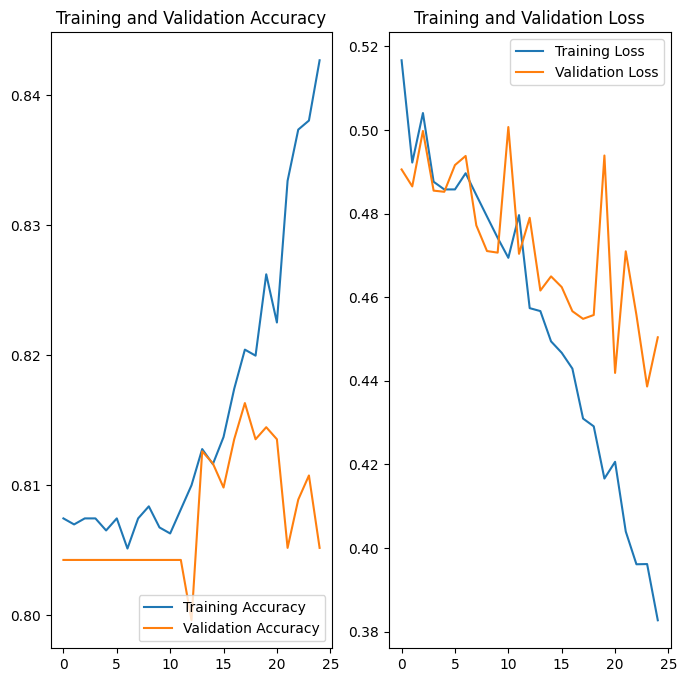

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


W0000 00:00:1724230618.680875      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


W0000 00:00:1724230622.123875      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


              precision    recall  f1-score   support

      benign       0.41      0.07      0.11       182
    melanoma       0.54      0.92      0.68       218

    accuracy                           0.53       400
   macro avg       0.48      0.49      0.40       400
weighted avg       0.48      0.53      0.42       400





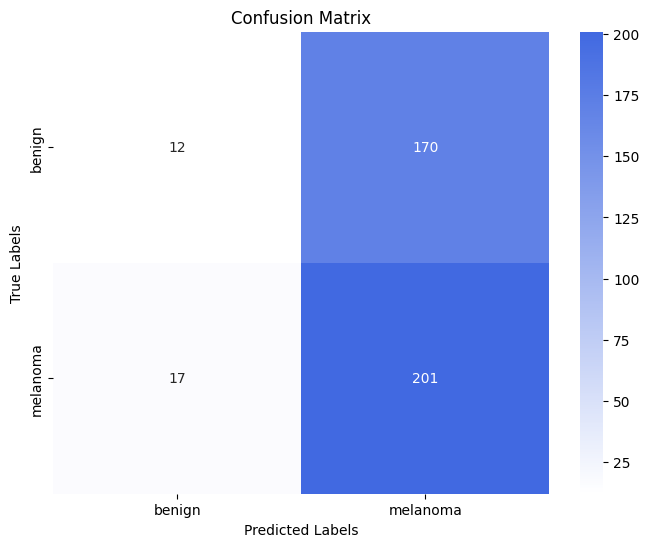

In [ ]:
evaluate_model_performance_bit(
    model, val_ds, class_labels
)

In [ ]:
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=42,
  validation_split = 0.2,
  subset = 'training',
  image_size=(180, 180),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=42,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(180, 180),
  batch_size=batch_size)

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Found 2000 files belonging to 2 classes.
Using 400 files for validation.


In [ ]:
from tensorflow.keras.layers import Rescaling,MaxPool2D

from tensorflow.keras.optimizers import Adam

In [ ]:
model = Sequential([Rescaling(1.0/255,input_shape=(180,180,3))])

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.20))

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=2, activation= 'softmax'))

In [ ]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer= opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
 3/50 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.5017 - loss: 0.8320

I0000 00:00:1724225018.290966      85 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1724225018.310483      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.4945 - loss: 0.7662

W0000 00:00:1724225033.064358      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 402ms/step - accuracy: 0.4949 - loss: 0.7653 - val_accuracy: 0.5450 - val_loss: 0.6869
Epoch 2/25


W0000 00:00:1724225038.041686      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 376ms/step - accuracy: 0.5338 - loss: 0.6873 - val_accuracy: 0.5000 - val_loss: 0.6924
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 364ms/step - accuracy: 0.5522 - loss: 0.6879 - val_accuracy: 0.5475 - val_loss: 0.6837
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 376ms/step - accuracy: 0.5727 - loss: 0.6806 - val_accuracy: 0.4625 - val_loss: 0.6961
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 360ms/step - accuracy: 0.5277 - loss: 0.6875 - val_accuracy: 0.4950 - val_loss: 0.6868
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 383ms/step - accuracy: 0.5540 - loss: 0.6877 - val_accuracy: 0.5300 - val_loss: 0.6880
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 374ms/step - accuracy: 0.5422 - loss: 0.6871 - val_accuracy: 0.4850 - val_loss: 0.7073
Epoch 8/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 373ms/step - accuracy: 0.5009 - loss: 0.7056 - val_accuracy: 0.4550 - val_loss: 0.6948
Epoch 9/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 386ms/step - accuracy: 0.5012 - loss: 0.6933 - val_accuracy: 0.455

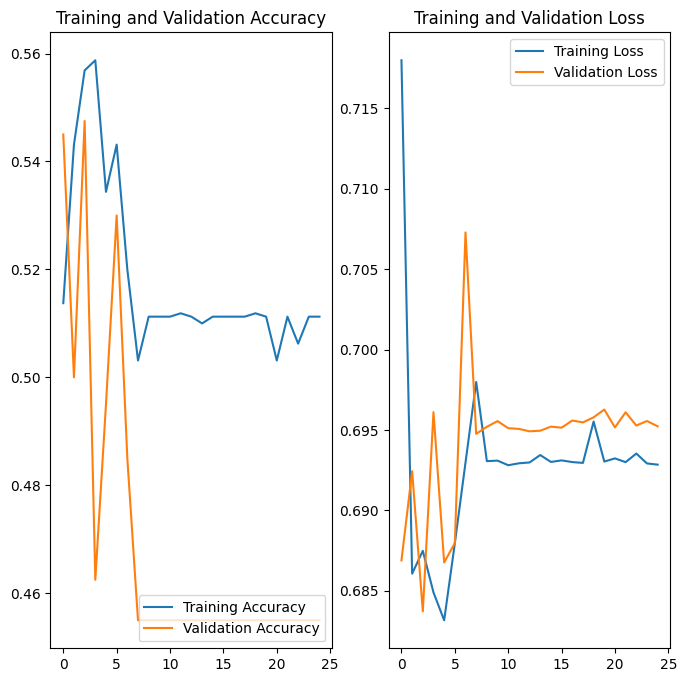

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()